In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('./4_1_kagle_dataset/3_survey/1_data/survey.csv')
display(df.head())

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [9]:
df = df.drop(["Timestamp","Country","state","comments"], axis=1)

In [10]:
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

# Create lists by data tpe
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']
floatFeatures = []

# Clean the NaN's
for feature in df:
    if feature in intFeatures:
        df[feature] = df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        df[feature] = df[feature].fillna(defaultString)
    elif feature in floatFeatures:
        df[feature] = df[feature].fillna(defaultFloat)
    else:
        print('Error: Feature %s not recognized.' % feature)

In [11]:
#Genderを小文字に統一しユニーク値を確認する
gender = df['Gender'].str.lower()
# print(gender.unique())

In [12]:
male_str = ['m','male','male-ish','maile','cis male','mal','male (cis)','make','guy (-ish) ^_^','male ','man','msle','mail','malr','cis man']
female_str = ['f','female','cis female','woman','femake','female','cis-female/femme','female (cis)','femail',]
for (row, col) in df.iterrows():
    if str.lower(col.Gender) in male_str:
        df['Gender'].replace(to_replace=col.Gender, value='m', inplace=True)
    elif str.lower(col.Gender) in female_str:
        df['Gender'].replace(to_replace=col.Gender, value='f', inplace=True)
    else:
        df['Gender'].replace(to_replace=col.Gender, value='unknown', inplace=True)

In [13]:
df['self_employed'] = df['self_employed'].replace([defaultString], 'No')
# print(df['self_employed'].unique())
df['work_interfere'] = df['work_interfere'].replace([defaultString], 'Don\'t know' )
# print(df['work_interfere'].unique())

In [17]:
#LabelEncoder
for feature in df:
    le = preprocessing.LabelEncoder()
    le.fit(df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    df[feature] = le.transform(df[feature])

df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,25,0,0,0,1,2,4,0,1,2,...,2,2,1,1,1,2,1,0,2,0
1,32,1,0,0,0,3,5,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,20,1,0,0,0,3,4,0,1,1,...,0,1,1,1,2,2,2,2,1,0
3,19,1,0,1,1,2,2,0,1,1,...,1,1,2,2,1,0,0,0,1,1
4,19,1,0,0,0,1,1,1,1,2,...,0,0,1,1,1,2,2,2,0,0


In [18]:
# 説明変数
X = df.drop(["treatment"], axis=1)
# 目的変数
y = df["treatment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [46]:
# 決定木を実施
dtc = DecisionTreeClassifier(criterion="gini", max_depth=1, min_samples_split=2, min_samples_leaf=3, random_state=1234)
dtc.fit(X_train, y_train)
# スコアの確認
print("score=", dtc.score(X_test,y_test).round(3))
# モデルの精度を確認
y_pred = dtc.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

score= 0.81
             precision    recall  f1-score   support

          0       0.91      0.69      0.78       188
          1       0.75      0.93      0.83       190

avg / total       0.83      0.81      0.81       378

[[129  59]
 [ 13 177]]


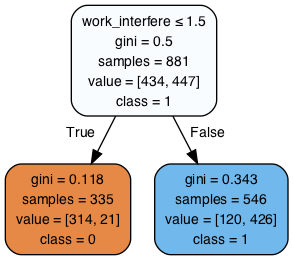

In [47]:
# 決定木の描画
dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(dtc, out_file=dot_data, feature_names=X_train.columns, class_names=["0","1"], filled=True, rounded=True, special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

In [48]:
param_grid = {'max_depth':[1,2,3,4,5]}
cv = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [49]:
cv.best_params_

{'max_depth': 1}

In [50]:
cv.grid_scores_

/Users/t.suzuki/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.83995, std: 0.01219, params: {'max_depth': 1},
 mean: 0.83995, std: 0.01219, params: {'max_depth': 2},
 mean: 0.83995, std: 0.01219, params: {'max_depth': 3},
 mean: 0.82293, std: 0.01658, params: {'max_depth': 4},
 mean: 0.81498, std: 0.01283, params: {'max_depth': 5}]

In [51]:
print(classification_report(y_test,cv.best_estimator_.predict(X_test)))
print(confusion_matrix(y_test,cv.best_estimator_.predict(X_test)))

             precision    recall  f1-score   support

          0       0.91      0.69      0.78       188
          1       0.75      0.93      0.83       190

avg / total       0.83      0.81      0.81       378

[[129  59]
 [ 13 177]]
